In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.arima.model import ARIMA
import sklearn.metrics
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_squared_error
from math import sqrt
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
import pmdarima as pmd
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import lightgbm as lgb
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_absolute_error

/Users/lezhang/Documents/learning/repos/venv/genai-venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


### ARIMA

            Sales
Month            
1901-01-01  266.0
1901-02-01  145.9
1901-03-01  183.1
1901-04-01  119.3
1901-05-01  180.3


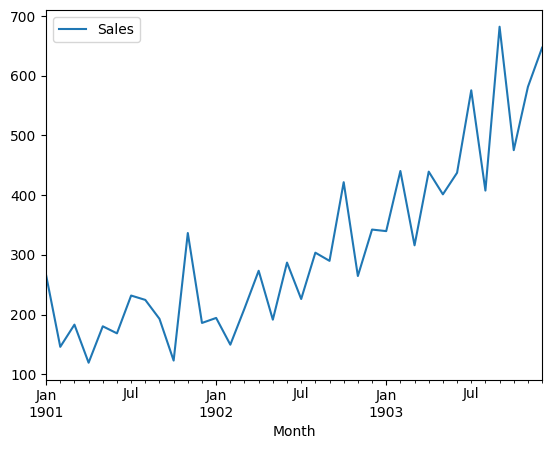

In [2]:
series = pd.read_csv('shampoo.csv', header=0)
series['Month'] = '190'+series['Month']
series['Month'] = pd.to_datetime(series['Month'], format='%Y-%m')
series.set_index('Month', inplace=True)
print(series.head())
series.plot()
plt.show()

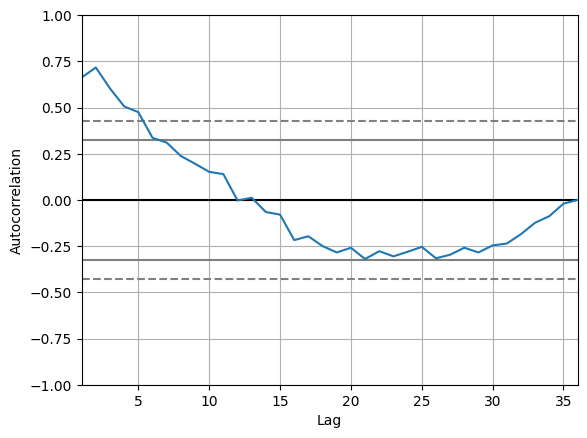

In [3]:
autocorrelation_plot(series)
plt.show()

                               SARIMAX Results                                
Dep. Variable:                  Sales   No. Observations:                   36
Model:                 ARIMA(5, 1, 0)   Log Likelihood                -198.485
Date:                Thu, 27 Jun 2024   AIC                            408.969
Time:                        09:11:51   BIC                            418.301
Sample:                    01-31-1901   HQIC                           412.191
                         - 12-31-1903                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9014      0.247     -3.647      0.000      -1.386      -0.417
ar.L2         -0.2284      0.268     -0.851      0.395      -0.754       0.298
ar.L3          0.0747      0.291      0.256      0.7

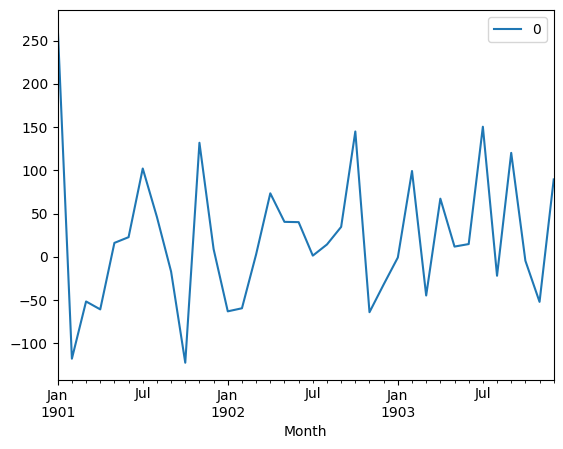

In [4]:
# fit an ARIMA model and plot residual errors
series.index = series.index.to_period('M')
# fit model
model = ARIMA(series, order=(5,1,0))
model_fit = model.fit()
# summary of fit model
print(model_fit.summary())
# line plot of residuals
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()
plt.show()

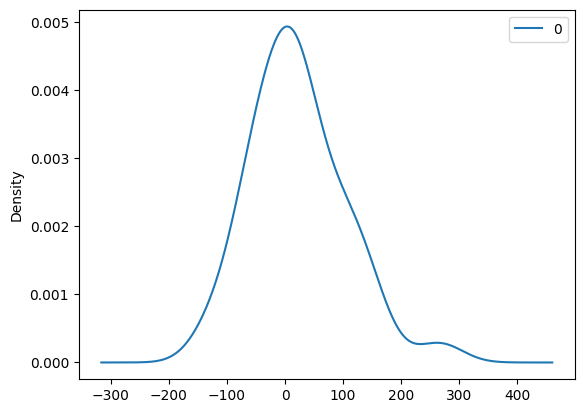

                0
count   36.000000
mean    21.936144
std     80.774430
min   -122.292030
25%    -35.040859
50%     13.147218
75%     68.848286
max    266.000000


In [5]:
# density plot of residuals
residuals.plot(kind='kde')
plt.show()
# summary stats of residuals
print(residuals.describe())

/var/folders/ry/5l37ld9j319_17ytxrp8r3r00000gn/T/ipykernel_55585/818625450.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('predicted=%f, expected=%f' % (yhat, obs))


predicted=343.272180, expected=342.300000
predicted=293.329674, expected=339.700000
predicted=368.668956, expected=440.400000
predicted=335.044741, expected=315.900000
predicted=363.220222, expected=439.300000
predicted=357.645324, expected=401.300000
predicted=443.047835, expected=437.400000
predicted=378.365674, expected=575.500000
predicted=459.415021, expected=407.600000
predicted=526.890876, expected=682.000000
predicted=457.231274, expected=475.300000
predicted=672.914943, expected=581.300000
predicted=531.541449, expected=646.900000
Test RMSE: 89.021


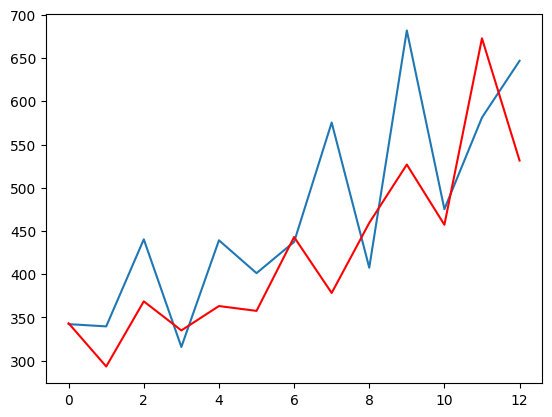

In [6]:
# split into train and test sets
X = series.values
size = int(len(X) * 0.66)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()
# walk-forward validation
for t in range(len(test)):
    model = ARIMA(history, order=(5,1,0))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)
    print('predicted=%f, expected=%f' % (yhat, obs))
# evaluate forecasts
rmse = sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % rmse)
# plot forecasts against actual outcomes
plt.plot(test)
plt.plot(predictions, color='red')
plt.show()

### SARIMA

<Axes: xlabel='Month'>

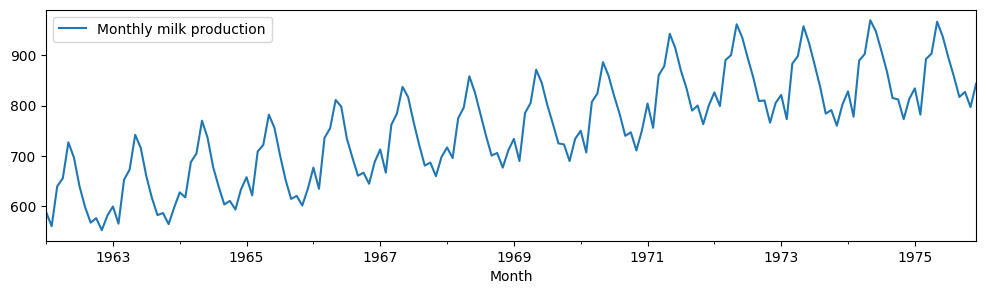

In [7]:
df = pd.read_csv('monthlyMilkProduction.csv')
df['Month'] = pd.to_datetime(df['Month'], format='%Y-%m')
df.set_index('Month', inplace=True)
train = df.iloc[:-24, :]
test = df.iloc[-24:, :]
train.index = pd.to_datetime(train.index)
test.index = pd.to_datetime(test.index)
pred = test.copy()
df.plot(figsize=(12,3))

<Axes: xlabel='Lag', ylabel='Autocorrelation'>

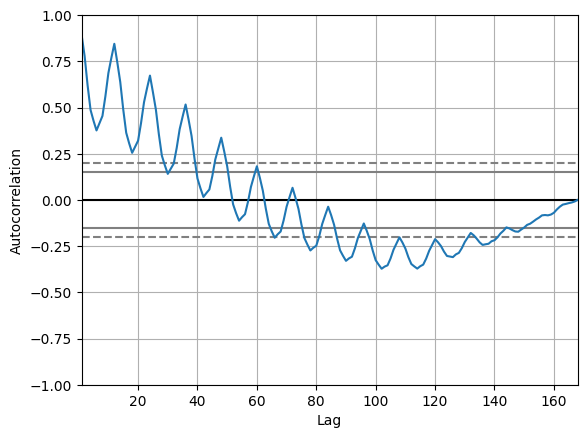

In [8]:
autocorrelation_plot(df)

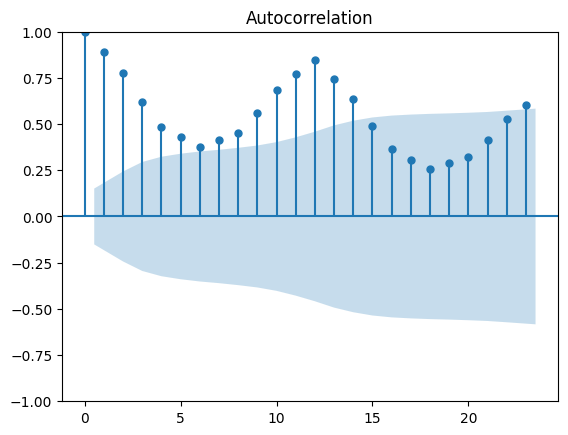

In [8]:
plot_acf(df)
plt.show()

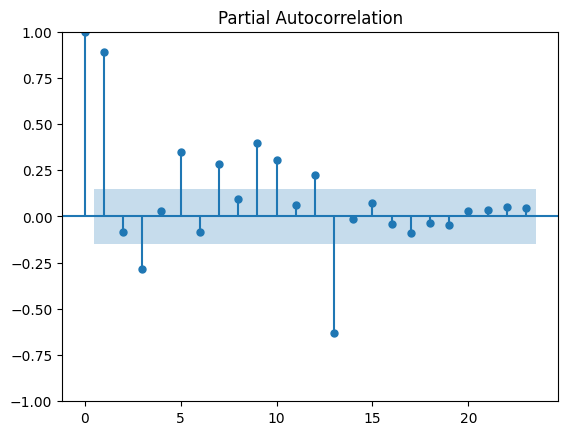

In [9]:
plot_pacf(df)
plt.show()

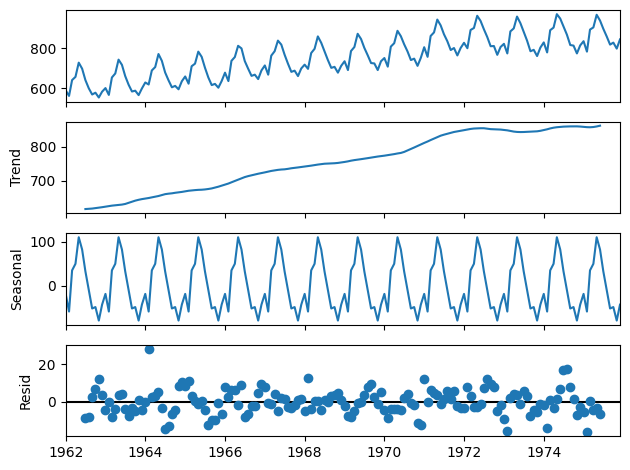

In [10]:
decomposition=seasonal_decompose(df,model='additive',period=12)
decomposition.plot()
plt.show()

In [11]:
dftest = adfuller(df, autolag = 'AIC')
print("1. ADF : ",dftest[0])
print("2. P-Value : ", dftest[1])
print("3. Num Of Lags : ", dftest[2])
print("4. Num Of Observations Used For ADF Regression and Critical Values Calculation :", dftest[3])
print("5. Critical Values :")
for key, val in dftest[4].items():
    print("\t",key, ": ", val)

1. ADF :  -1.3038115874221246
2. P-Value :  0.627426708603034
3. Num Of Lags :  13
4. Num Of Observations Used For ADF Regression and Critical Values Calculation : 154
5. Critical Values :
	 1% :  -3.473542528196209
	 5% :  -2.880497674144038
	 10% :  -2.576878053634677


In [12]:
data_diff=df.diff(periods=12)

dftest = adfuller(data_diff.dropna(), autolag = 'AIC')
print("1. ADF : ",dftest[0])
print("2. P-Value : ", dftest[1])
print("3. Num Of Lags : ", dftest[2])
print("4. Num Of Observations Used For ADF Regression and Critical Values Calculation :", dftest[3])
print("5. Critical Values :")
for key, val in dftest[4].items():
    print("\t",key, ": ", val)

1. ADF :  -2.335419314359397
2. P-Value :  0.16079880527711382
3. Num Of Lags :  12
4. Num Of Observations Used For ADF Regression and Critical Values Calculation : 143
5. Critical Values :
	 1% :  -3.4769274060112707
	 5% :  -2.8819726324025625
	 10% :  -2.577665408088415


In [13]:
sarima=SARIMAX(df,order=(1,1,1),seasonal_order=(1,0,1,12))
predicted=sarima.fit().predict()
predicted

/Users/lezhang/Documents/learning/repos/venv/genai-venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/lezhang/Documents/learning/repos/venv/genai-venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/lezhang/Documents/learning/repos/venv/genai-venv/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.03337D+00    |proj g|=  4.69315D+00

At iterate    5    f=  4.77655D+00    |proj g|=  2.36527D-02

At iterate   10    f=  4.58802D+00    |proj g|=  1.57657D-01

At iterate   15    f=  3.65894D+00    |proj g|=  2.77231D-01

At iterate   20    f=  3.54001D+00    |proj g|=  4.22693D-02

At iterate   25    f=  3.53096D+00    |proj g|=  6.11856D-04

At iterate   30    f=  3.53041D+00    |proj g|=  2.52451D-03

At iterate   35    f=  3.53031D+00    |proj g|=  3.55166D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function 

1962-01-01      0.000000
1962-02-01    588.717567
1962-03-01    566.868981
1962-04-01    623.512389
1962-05-01    651.887466
                 ...    
1975-08-01    855.568560
1975-09-01    808.806541
1975-10-01    817.533954
1975-11-01    788.918197
1975-12-01    835.379664
Freq: MS, Name: predicted_mean, Length: 168, dtype: float64

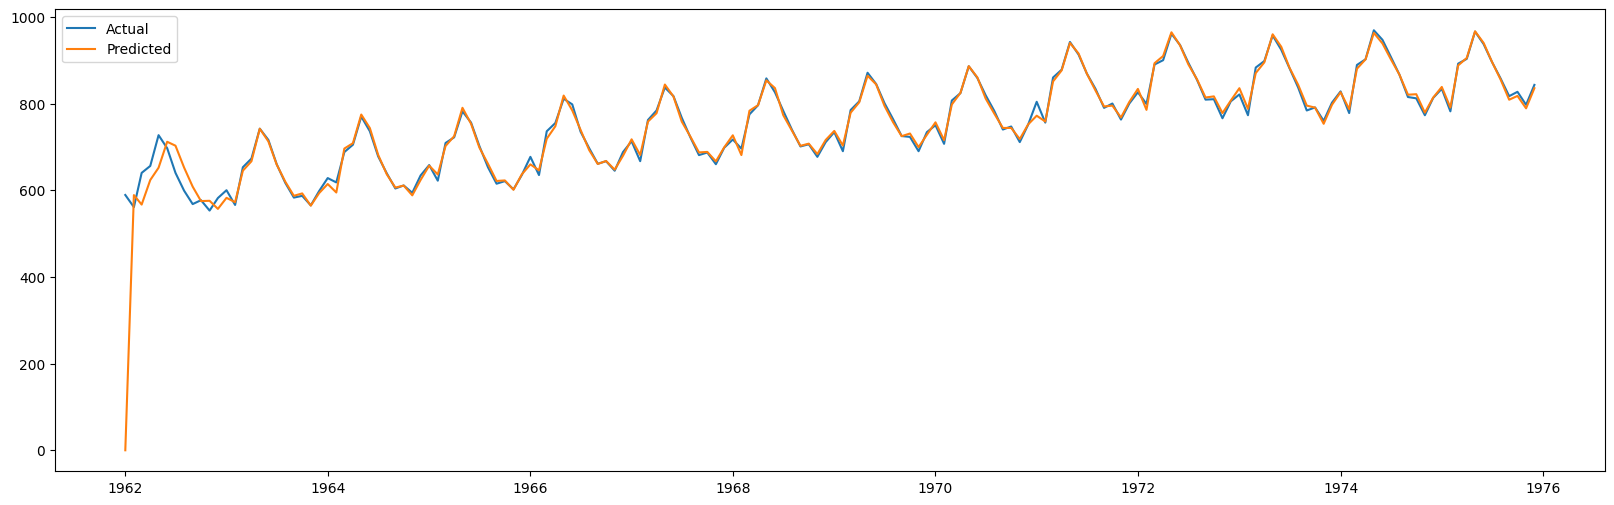

In [14]:
plt.figure(figsize=(20,6))
plt.plot(df.squeeze(),label='Actual')
plt.plot(predicted,label='Predicted')
plt.legend()

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(1,1,1)[12]             : AIC=913.483, Time=0.50 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=957.723, Time=0.03 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=924.186, Time=0.08 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=909.628, Time=0.12 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=947.438, Time=0.04 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=911.570, Time=0.16 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=911.554, Time=0.37 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=923.982, Time=0.07 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=inf, Time=1.55 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=917.927, Time=0.08 sec
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=911.554, Time=0.16 sec
 ARIMA(0,1,2)(0,1,1)[12]             : AIC=911.499, Time=0.19 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=910.254, Time=0.12 sec
 ARIMA(1,1,2)(0,1,1)[12]             : AIC=913.437, Time=0.41 sec
 ARIMA(0,1,1)(0,1,1)[12] intercept   

Text(0.5, 1.0, 'SARIMA')

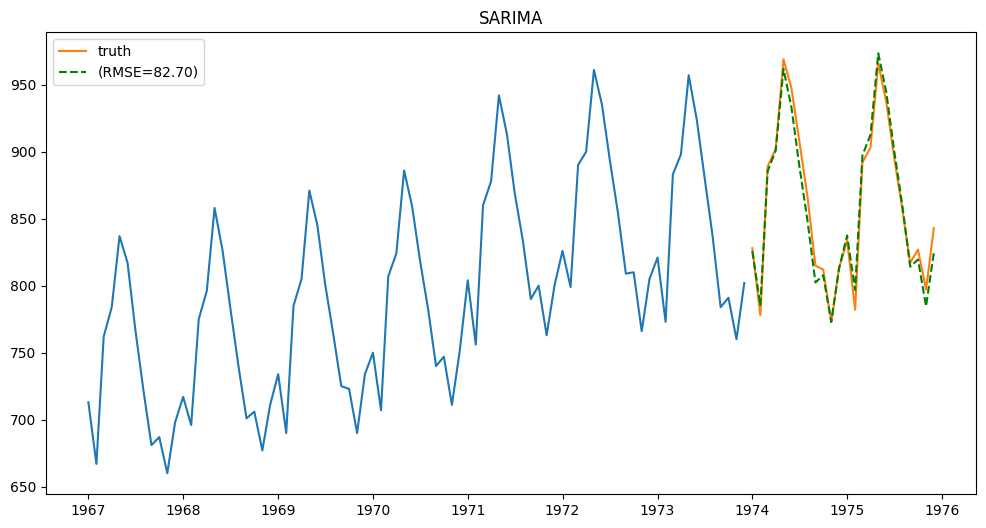

In [15]:
model=pmd.auto_arima(train,start_p=1,start_q=1,test='adf',m=12,seasonal=True,trace=True)
pred=model.predict(n_periods=24)

sse1 = np.sqrt(np.mean(np.square(test.values - pred.values)))

fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(train.index[60:], train.values[60:]);
ax.plot(test.index, test.values, label='truth');
ax.plot(test.index, pred, linestyle='--', color='green', label="(RMSE={:0.2f})".format(sse1));
ax.legend()
ax.set_title("SARIMA")

In [17]:
# model=pmd.auto_arima(train,start_p=1,start_q=1,test='adf',m=12,seasonal=True,trace=True)
# pred=model.predict(n_periods=24)
# pred

# temp=df.squeeze()
# temp1=pd.concat([predicted,pred])
# plt.figure(figsize=(20,6))
# plt.plot(temp,label='Actual')
# plt.plot(temp1,label='Predicted')
# plt.legend()

### Exponential Smoothing

<Axes: xlabel='Month'>

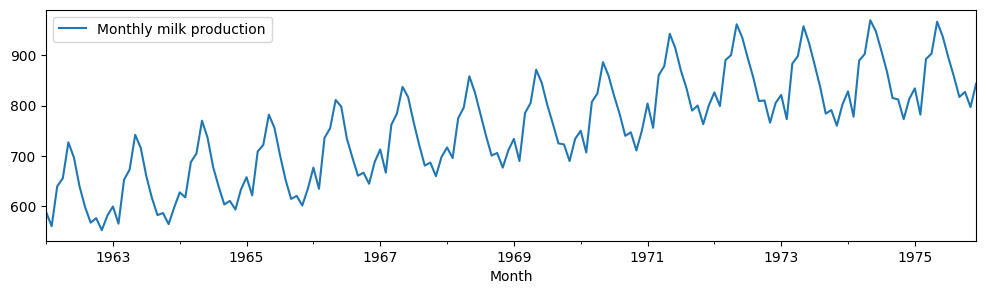

In [16]:
df = pd.read_csv('monthlyMilkProduction.csv')
df['Month'] = pd.to_datetime(df['Month'], format='%Y-%m')
df.set_index('Month', inplace=True)
train = df.iloc[:-24, :]
test = df.iloc[-24:, :]
train.index = pd.to_datetime(train.index)
test.index = pd.to_datetime(test.index)
pred = test.copy()
df.plot(figsize=(12,3))

/Users/lezhang/Documents/learning/repos/venv/genai-venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/var/folders/ry/5l37ld9j319_17ytxrp8r3r00000gn/T/ipykernel_55585/393506941.py:2: FutureWarning: the 'damped' keyword is deprecated, use 'damped_trend' instead.
  model2 = ExponentialSmoothing(train, trend="add", seasonal="add", seasonal_periods=12, damped=True)
/Users/lezhang/Documents/learning/repos/venv/genai-venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


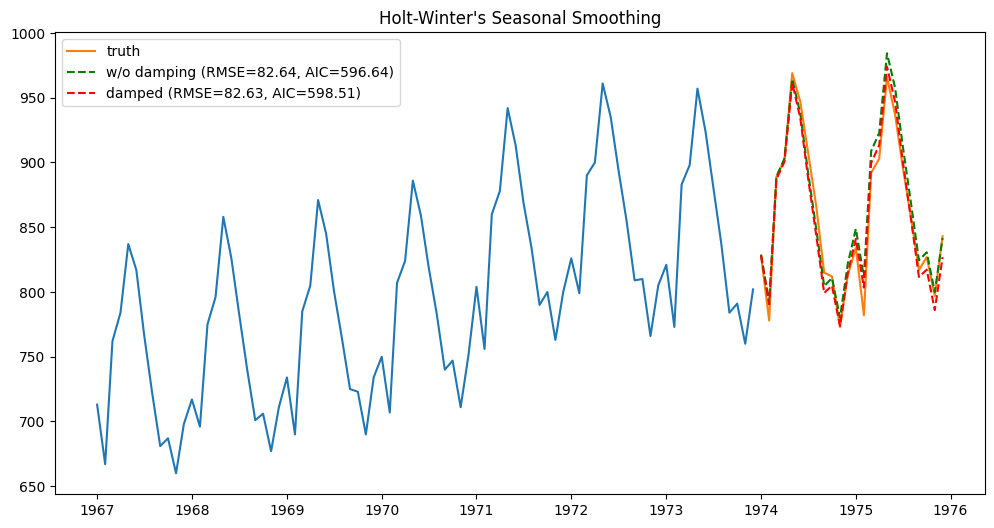

In [17]:
model = ExponentialSmoothing(train, trend="add", seasonal="add", seasonal_periods=12)
model2 = ExponentialSmoothing(train, trend="add", seasonal="add", seasonal_periods=12, damped=True)
fit = model.fit()
pred = fit.forecast(24)
fit2 = model2.fit()
pred2 = fit2.forecast(24)

sse1 = np.sqrt(np.mean(np.square(test.values - pred.values)))
sse2 = np.sqrt(np.mean(np.square(test.values - pred2.values)))

fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(train.index[60:], train.values[60:]);
ax.plot(test.index, test.values, label='truth');
ax.plot(test.index, pred, linestyle='--', color='green', label="w/o damping (RMSE={:0.2f}, AIC={:0.2f})".format(sse1, fit.aic));
ax.plot(test.index, pred2, linestyle='--', color='red', label="damped (RMSE={:0.2f}, AIC={:0.2f})".format(sse2, fit2.aic)); 
ax.legend();
ax.set_title("Holt-Winter's Seasonal Smoothing");

### Tree-based Model

In [29]:
# Load the dataset
url = 'https://raw.githubusercontent.com/jbrownlee/Datasets/master/airline-passengers.csv'
df = pd.read_csv(url, parse_dates=['Month'], index_col='Month')

# Extract month as a feature
df['Month_Feature'] = df.index.month

# One-hot encode the month feature
encoder = OneHotEncoder(sparse_output=False, drop="first")
month_encoded = encoder.fit_transform(df[['Month_Feature']])
month_encoded_df = pd.DataFrame(month_encoded, index=df.index, columns=[f'month_{i+1}' for i in range(month_encoded.shape[1])])

# Join the encoded features with the original dataframe
df = pd.concat([df, month_encoded_df], axis=1)
df[f'lag_{12}'] = df['Passengers'].shift(12)
df = df.dropna()

# Define training and testing datasets (last 12 months as test set)
train = df[:-12]
test = df[-12:]

# Prepare datasets for LightGBM
features = [f'month_{i+1}' for i in range(11)] + ["lag_12"]
X_train, y_train = train[features], train['Passengers']
X_test, y_test = test[features], test['Passengers']

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002165 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 61
[LightGBM] [Info] Number of data points in the train set: 120, number of used features: 12
[LightGBM] [Info] Start training from score 276.075000
RMSE: 50.277180093939


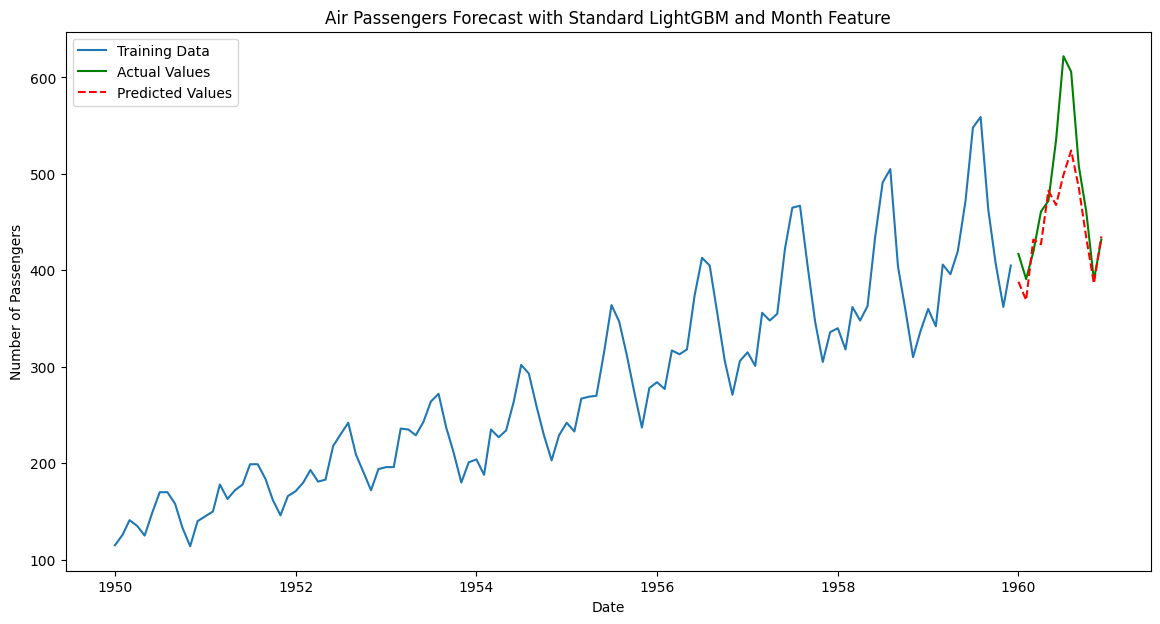

In [32]:
# Configure and train the LightGBM model
params = {
    'objective': 'regression',
    'metric': 'rmse',
    'num_leaves': 10,
    'learning_rate': 0.05,
    'feature_fraction': 0.9,
    'min_data_in_leaf': 5
}
train_data = lgb.Dataset(X_train, label=y_train)
gbm = lgb.train(params, train_data, num_boost_round=200)

# Forecast the next 12 months
y_pred = gbm.predict(X_test)

# Calculate RMSE for the predictions
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f'RMSE: {rmse}')

# Plotting the actual vs predicted values
plt.figure(figsize=(14, 7))
plt.plot(train.index, y_train, label='Training Data')
plt.plot(test.index, y_test, label='Actual Values', color='green')
plt.plot(test.index, y_pred, label='Predicted Values', linestyle='--', color='red')
plt.title('Air Passengers Forecast with Standard LightGBM and Month Feature')
plt.xlabel('Date')
plt.ylabel('Number of Passengers')
plt.legend()
plt.show()

In [35]:
# Load the dataset
df = pd.read_csv('monthlyMilkProduction.csv')
df['Month'] = pd.to_datetime(df['Month'], format='%Y-%m')
df.set_index('Month', inplace=True)

# Extract month as a feature
df['Month_Feature'] = df.index.month

# One-hot encode the month feature
encoder = OneHotEncoder(sparse_output=False, drop="first")
month_encoded = encoder.fit_transform(df[['Month_Feature']])
month_encoded_df = pd.DataFrame(month_encoded, index=df.index, columns=[f'month_{i+1}' for i in range(month_encoded.shape[1])])

# Join the encoded features with the original dataframe
df = pd.concat([df, month_encoded_df], axis=1)
df[f'lag_{12}'] = df['Monthly milk production'].shift(12)
df = df.dropna()

# Define training and testing datasets (last 12 months as test set)
train = df[:-24]
test = df[-24:]

# Prepare datasets for LightGBM
features = [f'month_{i+1}' for i in range(11)] + ["lag_12"]
X_train, y_train = train[features], train['Monthly milk production']
X_test, y_test = test[features], test['Monthly milk production']

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000538 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 66
[LightGBM] [Info] Number of data points in the train set: 132, number of used features: 12
[LightGBM] [Info] Start training from score 748.098485
RMSE: 12.173654538320122


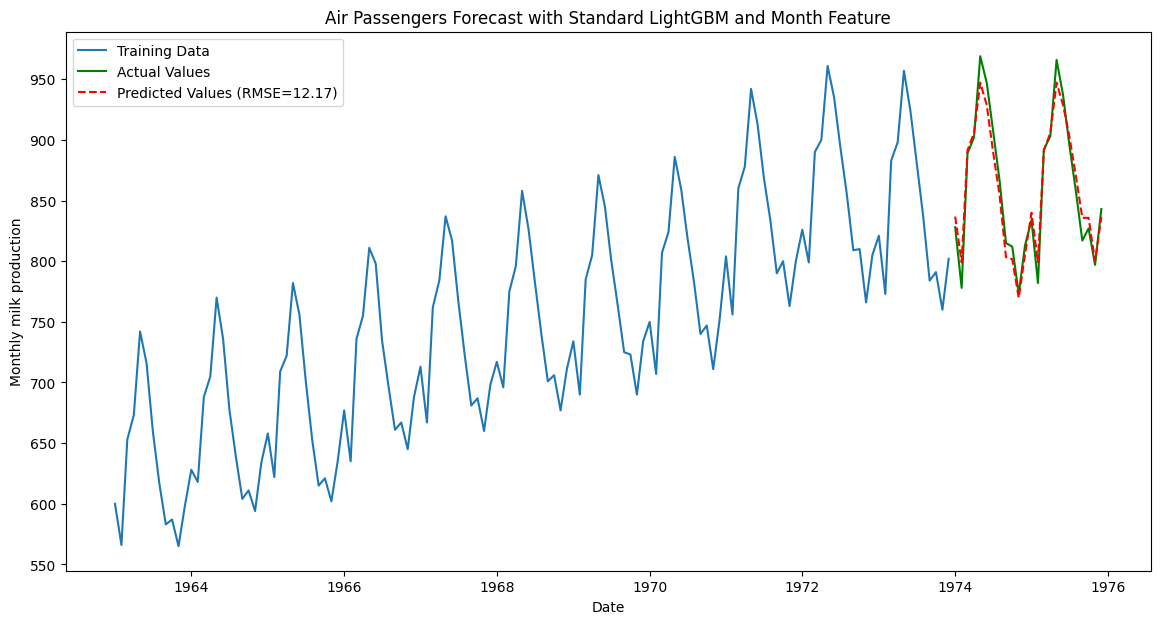

In [38]:
# Configure and train the LightGBM model
params = {
    'objective': 'regression',
    'metric': 'rmse',
    'num_leaves': 10,
    'learning_rate': 0.05,
    'feature_fraction': 0.9,
    'min_data_in_leaf': 5
}
train_data = lgb.Dataset(X_train, label=y_train)
gbm = lgb.train(params, train_data, num_boost_round=200)

# Forecast the next 12 months
y_pred = gbm.predict(X_test)

# Calculate RMSE for the predictions
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f'RMSE: {rmse}')

# Plotting the actual vs predicted values
plt.figure(figsize=(14, 7))
plt.plot(train.index, y_train, label='Training Data')
plt.plot(test.index, y_test, label='Actual Values', color='green')
plt.plot(test.index, y_pred, label='Predicted Values (RMSE={:0.2f})'.format(rmse), linestyle='--', color='red')
plt.title('Air Passengers Forecast with Standard LightGBM and Month Feature')
plt.xlabel('Date')
plt.ylabel('Monthly milk production')
plt.legend()
plt.show()

### Evaluation Metrics

#### RMSE

In [39]:
# Calculate MSE
mse = mean_squared_error(y_test, y_pred)

# Calculate RMSE
rmse = np.sqrt(mse)

print("RMSE:", rmse)

RMSE: 12.173654538320122


#### MAE

In [40]:
# Calculate MAE
mae = mean_absolute_error(y_test, y_pred)
print("Mean Absolute Error:", mae)

Mean Absolute Error: 10.35055575973045


#### MAPE

In [42]:
# Calculate MAPE
mape = mean_absolute_percentage_error(y_test, y_pred) * 100
print("MAPE:", mape, "%")

MAPE: 1.2019133374399573 %


#### sMAPE

In [43]:
# Define function
def sym_mean_absolute_percentage_error(actual, predicted):
    """
    Calculate SMAPE (Symmetric Mean Absolute Percentage Error).
    """
    return 2 * np.mean(np.abs(actual - predicted) / (np.abs(actual) + np.abs(predicted))) * 100

# Calculate SMAPE
smape = sym_mean_absolute_percentage_error(y_test, y_pred)
print("SMAPE:", smape, "%")

SMAPE: 1.2021649261852903 %


#### MASE

In [44]:
def mean_absolute_scaled_error(actual, predicted):
    """
    Calculate MASE (Mean Absolute Scaled Error).
    """
    mae = mean_absolute_error(actual, predicted)
    naive_error = np.mean(np.abs(actual[1:].values - actual[:-1].values))
    return mae / naive_error

# Calculate MASE
mase = mean_absolute_scaled_error(y_test, y_pred)
print("MASE:", mase)

MASE: 0.24567882608235328
